In [1]:
import torch
import math
import matplotlib.pyplot as plt

In [2]:
def generate_data(n, center, radius):
    random_tensor = torch.empty((n, 2)).uniform_(0, 1)
    radius_sq = math.pow(radius, 2)
    
    temp_tensor = random_tensor.sub(center).pow(2).sum(1)
    target_tensor = torch.where(temp_tensor < radius_sq, 1, 0)
    
    return random_tensor, target_tensor

n = 1000
center = 0.5
radius = 1 / math.sqrt((2 * math.pi))

train_data, train_target = generate_data(n, center, radius)
test_data, test_target = generate_data(n, center, radius)

In [ ]:
plt.scatter(test_data[:, :1], test_data[:, 1:])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_aspect('equal', adjustable='box')
plt.scatter(test_data[:, :1], test_data[:, 1:], marker=".")

circle1 = plt.Circle((center, center), radius, fill=False, linewidth=2)
plt.gca().add_patch(circle1)

In [3]:
from modules import Linear, Sequential, ReLU, Tanh, MSELoss, Sigmoid
from optimizers import SGD

def train_model(model, train_input, train_target, mini_batch_size, lossType = "MSE"):
    criterion = MSELoss()
    #if (lossType ==  "CrossEntropy"):
    #    criterion = CrossEntropyLoss()
    
    # keep track of loss during training
    log_losses = []

    optimizer = SGD(model.param())
    
    nb_epochs = 200
    for e in range(nb_epochs):
        mean_losses = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model.forward(train_input.narrow(0, b, mini_batch_size))
            
            loss = criterion.forward(output, train_target.narrow(0, b, mini_batch_size))
            mean_losses += loss.mean().item()
            
            model.zero_grad()
            
            loss_grad = criterion.backward()
            model.backward(loss_grad)
            
            optimizer.step()
            
        log_losses.append(mean_losses)
        
    return log_losses
            
def compute_nb_errors(model, input, target, mini_batch_size):
    error_count = 0
    # keep track of indices of wrong predictions for plot
    error_indices = []
    temp = input.clone()
    for b in range(0, train_data.size(0), mini_batch_size):
        output = model.forward(temp.narrow(0, b, mini_batch_size))
        #print(output)

        predicted_classes = torch.where(output < 0.5, 0, 1)
        #print(predicted_classes)
        for k in range(mini_batch_size):
            if target[b + k] != predicted_classes[k]:
                error_indices.append((b+k))
                error_count += 1
    return error_count, error_indices

In [12]:
def plot_circle(nb_errors, error_indices):
    wrong = torch.zeros([1000, 2])
    for i in error_indices:
        wrong[i, :] =  test_data[i, :]

    wrong = wrong[wrong[:, :] != 0].view([nb_errors, 2])    

    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [5, 5]
    ax = fig.add_subplot()
    ax.set_aspect('equal', adjustable='box')
    plt.scatter(test_data[:, :1], test_data[:, 1:], marker=".", c="g")
    plt.scatter(wrong[:, :1], wrong[:, 1:], marker=".", c="r")

    circle1 = plt.Circle((center, center), radius, fill=False, linewidth=2)
    plt.gca().add_patch(circle1)

In [7]:
def plot_losses(list_losses, list_labels):
    for i in range(len(list_losses)):
        plt.plot(list_losses[i], label=list_labels[i])
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

Number of errors: 14


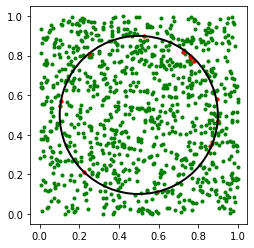

In [8]:
mini_batch_size = 100
train_data, train_target = generate_data(n, center, radius)
test_data, test_target = generate_data(n, center, radius)

model = Sequential([Linear(2, 25), Tanh(), Linear(25, 25), Tanh(), Linear(25, 25), Tanh(), Linear(25, 25), Tanh(), Linear(25, 1), Sigmoid()])
log_losses = train_model(model, train_data, train_target, mini_batch_size)
nb_errors, error_indices = compute_nb_errors(model, test_data, test_target, mini_batch_size)
print("Number of errors: " + str(nb_errors))
#print(log_losses)
#print(training_errors)

plot_circle(nb_errors, error_indices)

Number of errors: 16


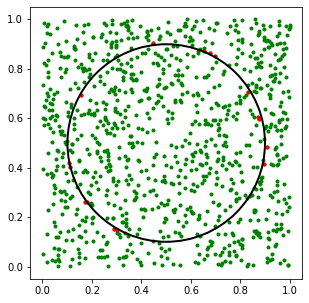

In [16]:
train_data, train_target = generate_data(n, center, radius)
test_data, test_target = generate_data(n, center, radius)

model = Sequential([Linear(2, 25, "He"), ReLU(), Linear(25, 25, "He"), ReLU(), Linear(25, 25, "He"), ReLU(), Linear(25, 25, "He"), ReLU(), Linear(25, 1), Sigmoid()])
log_losses1 = train_model(model, train_data, train_target, mini_batch_size, "MSE")
nb_errors, error_indices = compute_nb_errors(model, test_data, test_target, mini_batch_size)
print("Number of errors: " + str(nb_errors))

plot_circle(nb_errors, error_indices)

Number of errors: 20


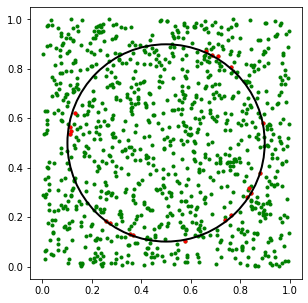

In [14]:
train_data, train_target = generate_data(n, center, radius)
test_data, test_target = generate_data(n, center, radius)

model = Sequential([Linear(2, 25), Tanh(), Linear(25, 25), Tanh(), Linear(25, 25), Tanh(), Linear(25, 25), Tanh(), Linear(25, 1), Sigmoid()])
log_losses2 = train_model(model, train_data, train_target, mini_batch_size, "MSE")
nb_errors, error_indices = compute_nb_errors(model, test_data, test_target, mini_batch_size)
print("Number of errors: " + str(nb_errors))

plot_circle(nb_errors, error_indices)

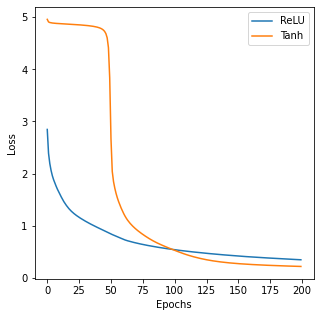

In [17]:
list_losses = [log_losses1, log_losses2]
list_labels = ["ReLU", "Tanh"]
plot_losses(list_losses, list_labels)

In [18]:
mini_batch_size = 100
n = 1000
center = 0.5
radius = 1 / math.sqrt((2 * math.pi))
import time 
import statistics

def run_model(model, nbr_runs):
    error_logs = []
    runtimes = []
    for i in range(nbr_runs):
        # Generate train and test data
        train_data, train_target = generate_data(n, center, radius)
        test_data, test_target = generate_data(n, center, radius)

        # Train model and compute train and test errors
        start_time = time.time()
        log_losses = train_model(model, train_data, train_target, mini_batch_size, "MSE")
        runtimes.append(time.time() - start_time)

        # Output statistics
        nb_errors, _ = compute_nb_errors(model, train_data, train_target, mini_batch_size)
        print("Training errors: " + str(nb_errors) + ", Training error rate: " + str((nb_errors * 100 / n)) + "%")
        nb_errors, error_indices = compute_nb_errors(model, test_data, test_target, mini_batch_size)
        print("Test errors: " + str(nb_errors) + ", Test error rate: " + str((nb_errors * 100 / n)) + "%")
        print("==================")
        error_logs.append(nb_errors)
    print(f"Mean of test errors over %d runs: %f" % (nbr_runs, statistics.mean(error_logs)))
    print(f"Standard deviation of test errors over %d runs: %f" % (nbr_runs, statistics.stdev(error_logs)))
    print(f"Average training time: %f sec" % (statistics.mean(runtimes)))
    print("==================\n")
    return log_losses

In [19]:
# FINAL MODELS
    
print("================== MSE Loss ==================\n")
print("Model: 3 fully-connected layers with Tanh as activation function \n")
# Define 1st model
model = Sequential([Linear(2, 25), Tanh(), Linear(25, 25), Tanh(), Linear(25, 25), Tanh(), Linear(25, 25), Tanh(), Linear(25, 1), Sigmoid()])
log_losses = run_model(model, 10)

================== MSE Loss ==================

Model: 3 fully-connected layers with Tanh as activation function 

Training errors: 11, Training error rate: 1.1%
Test errors: 30, Test error rate: 3.0%
Training errors: 6, Training error rate: 0.6%
Test errors: 27, Test error rate: 2.7%
Training errors: 9, Training error rate: 0.9%
Test errors: 20, Test error rate: 2.0%
Training errors: 5, Training error rate: 0.5%
Test errors: 25, Test error rate: 2.5%
Training errors: 3, Training error rate: 0.3%
Test errors: 11, Test error rate: 1.1%
Training errors: 11, Training error rate: 1.1%
Test errors: 18, Test error rate: 1.8%
Training errors: 3, Training error rate: 0.3%
Test errors: 17, Test error rate: 1.7%
Training errors: 6, Training error rate: 0.6%
Test errors: 16, Test error rate: 1.6%
Training errors: 6, Training error rate: 0.6%
Test errors: 8, Test error rate: 0.8%
Training errors: 4, Training error rate: 0.4%
Test errors: 13, Test error rate: 1.3%
Mean of test errors over 10 runs: 

In [20]:
print("Model: 3 fully-connected layers with ReLU as activation function \n")
# Define 2nd model
model = Sequential([Linear(2, 25, "He"), ReLU(), Linear(25, 25, "He"), ReLU(), Linear(25, 25, "He"), ReLU(), Linear(25, 25, "He"), ReLU(), Linear(25, 1), Sigmoid()])
log_losses1 = run_model(model, 10)

Model: 3 fully-connected layers with ReLU as activation function 

Training errors: 25, Training error rate: 2.5%
Test errors: 25, Test error rate: 2.5%
Training errors: 18, Training error rate: 1.8%
Test errors: 18, Test error rate: 1.8%
Training errors: 12, Training error rate: 1.2%
Test errors: 12, Test error rate: 1.2%
Training errors: 9, Training error rate: 0.9%
Test errors: 11, Test error rate: 1.1%
Training errors: 10, Training error rate: 1.0%
Test errors: 23, Test error rate: 2.3%
Training errors: 8, Training error rate: 0.8%
Test errors: 17, Test error rate: 1.7%
Training errors: 6, Training error rate: 0.6%
Test errors: 16, Test error rate: 1.6%
Training errors: 9, Training error rate: 0.9%
Test errors: 12, Test error rate: 1.2%
Training errors: 4, Training error rate: 0.4%
Test errors: 13, Test error rate: 1.3%
Training errors: 7, Training error rate: 0.7%
Test errors: 21, Test error rate: 2.1%
Mean of test errors over 10 runs: 16.800000
Standard deviation of test errors o

Text(0, 0.5, 'Loss')

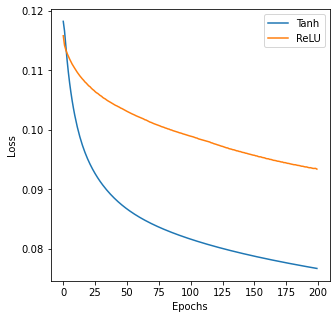

In [21]:
plt.plot(log_losses, label="Tanh")
plt.plot(log_losses1, label="ReLU")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")